# Teste do modelo Naive Bayes

## Importando dados

In [12]:
# Bibliotecas
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [15]:
# Importando dados
features = pd.read_csv("Features para trino.csv")
X_treino = features.drop("Unnamed: 0", axis=1).values

target = pd.read_csv("Target para treino.csv")
target = target["Class"]

X_teste = pd.read_csv("Features para teste.csv")
X_teste = X_teste.drop("Unnamed: 0", axis=1)
y_teste = pd.read_csv("Target para teste.csv")["Class"]

In [16]:
#Normalizando o target:
le = LabelEncoder()
nle = LabelEncoder()
target = le.fit_transform(target)
y_teste = nle.fit_transform(y_teste)

In [ ]:
#Selecionando features
from sklearn.feature_selection import SequentialFeatureSelector

modelo = GaussianNB()
seletor = SequentialFeatureSelector(
    modelo,
    n_features_to_select="auto",
    direction="backward",
    scoring="recall",
    cv = 5,
    n_jobs=-1
)
seletor.fit(features, target)

X_treino = seletor.transform(features)
X_teste = seletor.transform(X_teste)

print(f"Número original de atributos: {seletor.n_features_in_}")
print(f"Número de atributos selecionados: {seletor.n_features_to_select_}")
print(f"Colunas selecionadas: {seletor.support_}")


Número original de atributos: 134
Número de atributos selecionados: 67
Colunas selecionadas: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
  True False  True  True False False False False False False False  True
 False False False False  True False False False  True False  True False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


C:\Users\vitor25023\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SequentialFeatureSelector was fitted without feature names
  warnings.warn(


In [17]:
# Preparando a otimização de hiperparâmetros com optuna
#Criando as funções auxiliares
def instancia_geral(trial, parametros, algoritmo):
    modelo = algoritmo(**parametros)
    return modelo

def objetivo_geral(trial, parametros, algoritmo):
    modelo = instancia_geral(trial, parametros, algoritmo)
    metricas = cross_val_score(
        modelo,
        features,
        target,
        scoring="recall",
        cv= 5
    )
    return metricas.mean()


def funcao_objetivo_parcial_log_reg(trial):
    parametros = {"var_smoothing": trial.suggest_float("var_smoothing", 1e-11, 1e-1, log=True)}
    return objetivo_geral(trial, parametros, GaussianNB)

In [18]:
NOME_DO_ESTUDO = "naive_bayes1"
estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

estudo_knn.optimize(funcao_objetivo_parcial_log_reg, n_trials=1000)

[I 2025-11-02 04:27:19,192] Using an existing study with name 'naive_bayes1' instead of creating a new one.
[I 2025-11-02 04:27:20,433] Trial 1000 finished with value: 0.6923076923076923 and parameters: {'var_smoothing': 1.3105806019498122e-09}. Best is trial 0 with value: 0.7065934065934065.
[I 2025-11-02 04:27:20,624] Trial 1001 finished with value: 0.5142857142857143 and parameters: {'var_smoothing': 0.0004317954442368466}. Best is trial 0 with value: 0.7065934065934065.
[I 2025-11-02 04:27:20,835] Trial 1002 finished with value: 0.6923076923076923 and parameters: {'var_smoothing': 1.0478999435840626e-10}. Best is trial 0 with value: 0.7065934065934065.
[I 2025-11-02 04:27:21,035] Trial 1003 finished with value: 0.6923076923076923 and parameters: {'var_smoothing': 2.239505691469021e-10}. Best is trial 0 with value: 0.7065934065934065.
[I 2025-11-02 04:27:21,207] Trial 1004 finished with value: 0.7065934065934065 and parameters: {'var_smoothing': 1.3776116340873352e-11}. Best is tria

In [ ]:
params = estudo_knn.best_trial.params

predictor = GaussianNB(**params)
predictor.fit(X_treino, target)
predicoes = predictor.predict(X_teste)

accuracy = accuracy_score(y_teste, predicoes)
print(accuracy)

y_pred_trans = le.inverse_transform(predicoes)

medida = cross_val_score(predictor, X_teste, y_teste, scoring="recall", cv=5)
print("Recall médio no conjunto de teste:", medida.mean())

0.8214285714285714
Recall médio no conjunto de teste: 0.54


['Control' 'Impaired']


<Axes: >

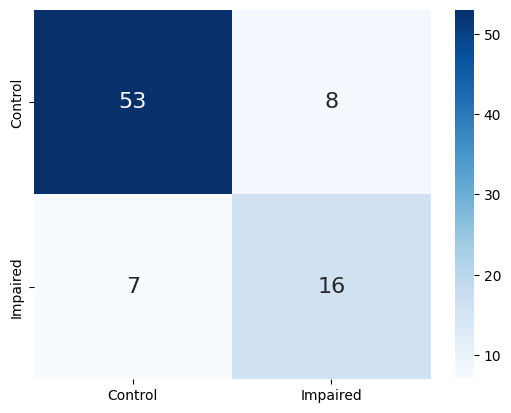

In [10]:
#Montando a matriz de confusão 
classes = np.unique(y_pred_trans)
Y = nle.inverse_transform(y_teste)
print(classes)
cm = confusion_matrix(Y, y_pred_trans, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, cmap="Blues")

In [14]:
print(classification_report(Y, y_pred_trans))

              precision    recall  f1-score   support

     Control       0.88      0.87      0.88        61
    Impaired       0.67      0.70      0.68        23

    accuracy                           0.82        84
   macro avg       0.77      0.78      0.78        84
weighted avg       0.82      0.82      0.82        84

